#The goal of this exploratory data analysis is to understand the influence of the external signals on ASML's performance in the stock exchange
#External signals to be considered are the following: US tech indices (Nasdaq, SOX), exchnage rates (EUR/USD), interest rates (US 10y, German 10y), market stress (VIX)
#We are specifically going to explore ASML'S daily abnormal returns moves rleative to the European market (abnormal returns vs EuroStoxx-50)
#Whether these relationships:
#1.Differ on lagged days (yesterday's signals vs today's ASML)
#2.Change under regimes (high vs low VIX)
#3. Look different on event days (ASML earnings, TSMC/NVDA earnings, ECB/FOMC announcements)

In [1]:
import pandas as pd #(data processing, CSV file)
import numpy as np #(linear algebra)
import yfinance as yf #(financial data)
#Charts
import matplotlib.pyplot as plt
import seaborn as sns

#Data I need to import
#ASML (Euronext Amsterdam): daily adjusted close prices.
#EuroStoxx-50: daily adjusted close prices.
#SOX (Philadelphia Semiconductor Index): daily prices.
#NASDAQ-100 (NDX): daily prices.
#EUR/USD exchange rate: daily quotes.
#VIX index: daily closing level.
#US 10y Treasury yield: daily yield.
#German 10y Bund yield: daily yield.

In [2]:
tickers = {
    'ASML': 'ASML.AS',
    'ESTX50': '^STOXX50E',
    'SOX':'^SOX',
    'NDX': '^NDX',
    'EURUSD': 'EURUSD=X',
    'VIX':'^VIX',
    'US10Y': '^TNX',
    #'DE10Y': 'DE10Y.BOND'
}
data = yf.download(list(tickers.values()), start = '2022-01-01', end = '2025-07-01')["Close"]
data.columns = tickers.keys()
print(data.head())

C:\Users\Anahit\AppData\Local\Temp\ipykernel_13592\1102720149.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.values()), start = '2022-01-01', end = '2025-07-01')["Close"]
[*********************100%***********************]  7 of 7 completed

                  ASML    ESTX50           SOX          NDX       EURUSD  \
Date                                                                       
2022-01-03  675.432068  1.137346  16501.769531  4027.219971  4331.819824   
2022-01-04  655.795715  1.130224  16279.730469  4009.000000  4367.620117   
2022-01-05  645.785095  1.128363  15771.780273  3879.870117  4392.149902   
2022-01-06  633.849365  1.131350  15765.360352  3909.040039  4324.810059   
2022-01-07  640.009644  1.129688  15592.190430  3796.320068  4305.830078   

              VIX      US10Y  
Date                          
2022-01-03  1.628  16.600000  
2022-01-04  1.668  16.910000  
2022-01-05  1.705  19.730000  
2022-01-06  1.733  19.610001  
2022-01-07  1.771  18.760000  


In [3]:
#Now I compute ASML abnormal daily log return = ASML return - EuroStoxx-50 return
#Compute log returns for price-based series
log_returns = np.log(data[['ASML', 'ESTX50', 'SOX', 'NDX', 'EURUSD']]/
                     data[['ASML', 'ESTX50', 'SOX', 'NDX', 'EURUSD']].shift(1))
#Compute changes for level-based series
changes = data[['VIX', 'US10Y']].diff()
#Build abnormal return (ASML vs EuroStoxx-50)
log_returns['ASML_abnormal'] = log_returns['ASML'] - log_returns['ESTX50']

#Merge into one tidy DataFrame
eda_data = pd.concat([log_returns, changes], axis=1).dropna()

#Rename the columns 
eda_data = eda_data.rename(columns={
    "ASML": "ASML_return",
    "ESTX50": "ESTX50_return",
    "SOX": "SOX_return",
    "NDX": "NDX_return",
    "EURUSD": "EURUSD_return",
    "VIX": "VIX_change",
    "US10Y": "US10Y_change"
})

print(eda_data.head())

#Price-based series are always positive and non-stationary as they don't stay around a fixed average. To study their day-to-day movements, we convert them into returns expressed as a percentage change.We use this approach to make them stationary and comparable.
#Level-based series have a certain range, and we are interested in changes and not returns.

            ASML_return  ESTX50_return  SOX_return  NDX_return  EURUSD_return  \
Date                                                                            
2022-01-04    -0.029503      -0.006281   -0.013547   -0.004534       0.008231   
2022-01-05    -0.015383      -0.001649   -0.031699   -0.032740       0.005601   
2022-01-06    -0.018655       0.002644   -0.000407    0.007490      -0.015451   
2022-01-07     0.009672      -0.001470   -0.011045   -0.029260      -0.004398   
2022-01-10    -0.066214       0.005040    0.001425    0.002386      -0.015520   

            ASML_abnormal  VIX_change  US10Y_change  
Date                                                 
2022-01-04      -0.023222       0.040      0.309999  
2022-01-05      -0.013734       0.037      2.820000  
2022-01-06      -0.021299       0.028     -0.119999  
2022-01-07       0.011142       0.038     -0.850000  
2022-01-10      -0.071254       0.009      0.639999  


In [4]:
#Now we need to compute descriptive statistics for ASML_abnormal which reflects the difference between ASML Stock return vs EuroStoxx-50 return 

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

In [6]:
#This gives few measures of descriptive statistics
descript_stats = eda_data['ASML_abnormal'].describe()
descript_stats.head()

count    802.000000
mean       0.000037
std        0.025133
min       -0.168639
25%       -0.014036
Name: ASML_abnormal, dtype: float64

In [7]:
skew = eda_data['ASML_abnormal'].skew()
skew

-0.30828268977457113

In [8]:
kurt = eda_data['ASML_abnormal'].kurtosis()
kurt

3.7459851202237417

In [9]:
print('Descriptive  stats for ASML abnormal return:')
print(descript_stats)
print(f'Skewness: {skew:.3f}')
print(f'Kurtosis: {kurt:.3f}')
#Skewness reflect whether the data is right-skew or left-skew based on whether positive jumps or negative drops are more /longer. so whetehr left/right tail is heavier
#Kurtosis measures how fat the tails are vs a bell curve. Kurtosis close to 0 means near normal tails, kurtosis bigger than 0 means fat tails, so more extreme than normal.
#We see negative skewness so it is left-skew and there are more negative drops than upside pops.

Descriptive  stats for ASML abnormal return:
count    802.000000
mean       0.000037
std        0.025133
min       -0.168639
25%       -0.014036
50%        0.000056
75%        0.013491
max        0.099043
Name: ASML_abnormal, dtype: float64
Skewness: -0.308
Kurtosis: 3.746


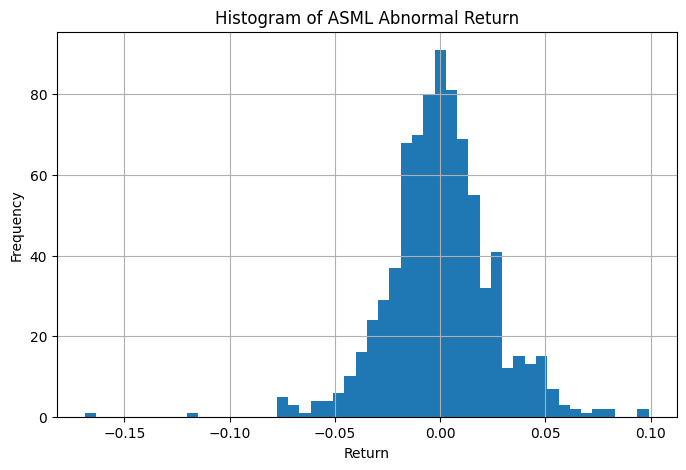

In [10]:
#Histogram
plt.figure(figsize=(8,5))
eda_data['ASML_abnormal'].hist(bins=50)
plt.title('Histogram of ASML Abnormal Return')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

In [11]:
#We need the smallest and largest returns as outliers to plot autocorrelation
print('\nTop 5 negative abnormal returns:')
print(eda_data['ASML_abnormal'].nsmallest(5))


Top 5 negative abnormal returns:
Date
2024-10-15   -0.168639
2024-07-17   -0.115865
2025-01-27   -0.077588
2022-01-24   -0.075443
2022-05-09   -0.073788
Name: ASML_abnormal, dtype: float64


In [12]:
print('\nTop 5 positive abnormal returns')
print(eda_data['ASML_abnormal'].nlargest(5))


Top 5 positive abnormal returns
Date
2022-11-10    0.099043
2024-01-24    0.094777
2024-06-05    0.080224
2025-01-06    0.079736
2022-10-19    0.076590
Name: ASML_abnormal, dtype: float64


#Autocorrelation reflects whether the series is correlated with itself at different tiem lags, so does today's abnormal return have a systematic link to yesterday's (lag=1)
#Lags = 20, means we consider autocorrelation within the span of 20 days
#We need autocorrelation to knwo whether there is predictability.
#We chose 20 days as 1 trading months is approx. 20 days.

<Figure size 800x500 with 0 Axes>

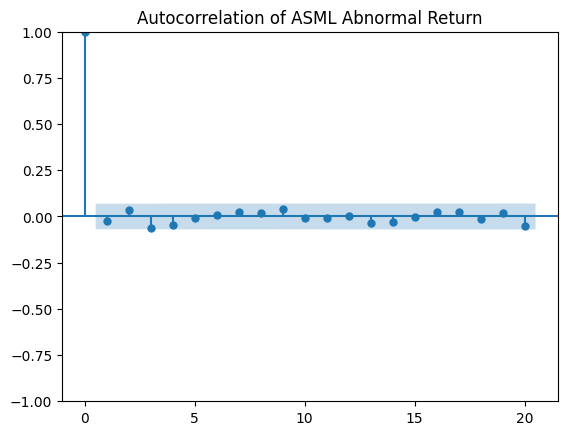

In [13]:
plt.figure(figsize=(8,5))
plot_acf(eda_data['ASML_abnormal'], lags = 20)
plt.title('Autocorrelation of ASML Abnormal Return')
plt.show()

If we look at the plot, we see that all the bars are inside the blue band meaning not statistically differetn from zero as the blue band is the confidence level (usually 95%). It means that if the true correlation were zero, random noise would still sometimes produce non-zero bars but 95% of them should fall inside this band. The first bra is 1 as it reflects the correlation with itself. So we see we don't have white noise.

As we have observed white noise in case of top smallest/largest abnormal returns, it means that those were not influenced by past returns. This means that those extremes were a result of an external event/announcement, macro surprises, etc.

#We will measure same-day (contemporaneous) links between ASML's abnormal return and each driver. We want to see which signals co-move the most with ASML on the same day.

In [14]:
#We select column, compute corr, take the target column, but only the driver rows; sort from highest to lowest 
drivers = ['SOX_return', 'NDX_return', 'EURUSD_return', 'VIX_change', 'US10Y_change']
corrs = eda_data[['ASML_abnormal'] + drivers].corr().loc[drivers, 'ASML_abnormal'].sort_values(ascending = False)
print('Contemporaneous correlations with ASML_abnormal (sorted):')
print(corrs)

Contemporaneous correlations with ASML_abnormal (sorted):
EURUSD_return    0.694116
NDX_return       0.548639
SOX_return       0.476971
VIX_change      -0.021124
US10Y_change    -0.251084
Name: ASML_abnormal, dtype: float64


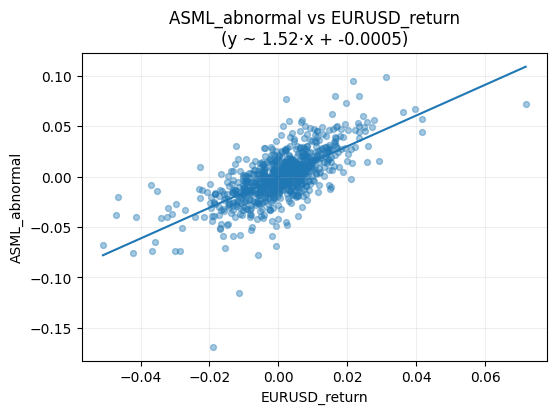

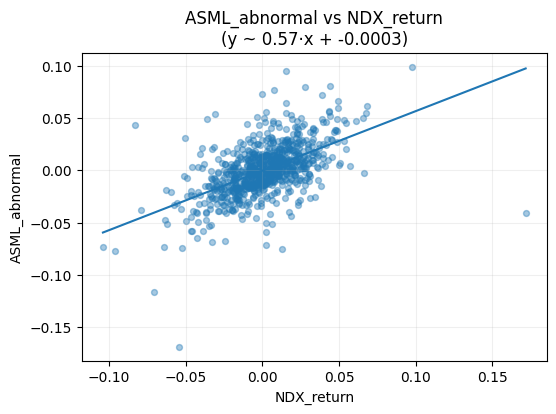

In [15]:
#Here we ranked drivers based on the absolute values of the correlation coefficients, in a descending order, extracted the top 2 and brought back the correct signs (original corrs)  
#top2 = corrs.reindex(corrs.abs().sort_va;ues(ascending = False).nlargest(2).index.tolist()
top2 = corrs.reindex(corrs.abs().sort_values(ascending = False).index[:2]).index.tolist()
for x in top2:
    xvals = eda_data[x].values
    yvals = eda_data['ASML_abnormal'].values
    plt.figure(figsize=(6,4))
    plt.scatter(xvals, yvals, alpha = 0.4, s=18)
    b1, b0 = np.polyfit(xvals, yvals, 1)
    xs = np.linspace(xvals.min(), xvals.max(), 100)
    plt.plot(xs, b1*xs + b0)
    plt.title(f"ASML_abnormal vs {x}\n(y ~ {b1:.2f}·x + {b0:.4f})")
    plt.xlabel(x)
    plt.ylabel("ASML_abnormal")
    plt.grid(alpha=0.2)
    plt.show()

In [16]:
#Outlier Robustness Check

In [17]:
#We trim top/bottom 1% of ASML_abnormal
low_q, high_q = 0.01, 0.99
low_val = eda_data['ASML_abnormal'].quantile(low_q)
high_val = eda_data['ASML_abnormal'].quantile(high_q)

trimmed = eda_data[(eda_data['ASML_abnormal'] >= low_val) & (eda_data['ASML_abnormal'] <= high_val)]
print(f'Original sample size: {len(eda_data)}')
print(f'Trimmed sample size: {len(trimmed)}')

Original sample size: 802
Trimmed sample size: 784


In [18]:
#Recalculate correlations with trimmed data
corrs_trimmed = trimmed[drivers].corrwith(trimmed['ASML_abnormal']).sort_values(ascending = False)
print('\nCorrelations after trimming:')
print(corrs_trimmed)


Correlations after trimming:
EURUSD_return    0.682366
NDX_return       0.511522
SOX_return       0.453540
VIX_change      -0.052241
US10Y_change    -0.216661
dtype: float64


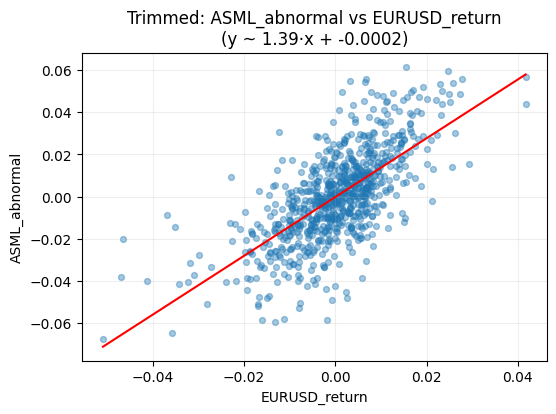

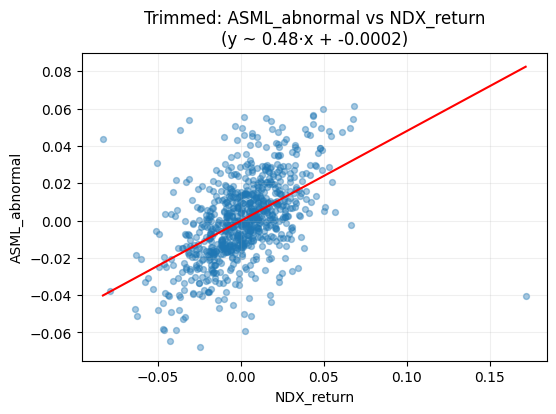

In [19]:
#We plot the scatterplots for the top 2 drivers after trimming
top2_trimmed = corrs_trimmed.abs().nlargest(2).index.tolist()
for x in top2_trimmed:
    xvals = trimmed[x].values
    yvals = trimmed['ASML_abnormal'].values
    plt.figure(figsize=(6,4))
    plt.scatter(xvals, yvals, alpha =0.4, s=18)
    b1,b0 = np.polyfit(xvals, yvals,1)
    xs= np.linspace(xvals.min(), xvals.max(), 100)
    plt.plot(xs, b1*xs + b0, color='red')
    plt.title(f"Trimmed: ASML_abnormal vs {x}\n(y ~ {b1:.2f}·x + {b0:.4f})")
    plt.xlabel(x)
    plt.ylabel("ASML_abnormal")
    plt.grid(alpha=0.2)
    plt.show()

Now, let's explore the lagged correlations

In [20]:
for col in drivers:
    eda_data[col + '_lag1'] = eda_data[col].shift(1)

lagged_corrs = eda_data[[col+'_lag1' for col in drivers]].corrwith(eda_data['ASML_abnormal']).sort_values(ascending = False)
print(lagged_corrs)
#We see that there is very slight positive or negative correlation for all 5 drivers which means that they carry almost no predictive power for them to influence ASML abnormal return

SOX_return_lag1       0.145320
NDX_return_lag1       0.134325
VIX_change_lag1       0.082343
EURUSD_return_lag1   -0.080867
US10Y_change_lag1    -0.116752
dtype: float64


In [21]:
# 0) Make sure you have the VIX level aligned
eda_data["VIX_level"] = data["VIX"].reindex(eda_data.index)

# 1) Define regimes on VIX LEVEL (clearer than changes)
low_thr  = eda_data["VIX_level"].quantile(0.20)   # bottom 20%
high_thr = eda_data["VIX_level"].quantile(0.80)   # top 20%

low_reg  = eda_data[eda_data["VIX_level"] <= low_thr]
high_reg = eda_data[eda_data["VIX_level"] >= high_thr]

print(f"Low-VIX n={len(low_reg)}, High-VIX n={len(high_reg)}")

# 2) Drop NaNs for each regime before corr
low_clean  = low_reg[["ASML_abnormal"] + drivers].dropna()
high_clean = high_reg[["ASML_abnormal"] + drivers].dropna()

# 3) Correlations in each regime
low_corrs  = low_clean[drivers].corrwith(low_clean["ASML_abnormal"]).sort_values(ascending=False)
high_corrs = high_clean[drivers].corrwith(high_clean["ASML_abnormal"]).sort_values(ascending=False)

print("\nCorrelations in LOW-VIX regime:")
print(low_corrs)
print("\nCorrelations in HIGH-VIX regime:")
print(high_corrs)


Low-VIX n=161, High-VIX n=161

Correlations in LOW-VIX regime:
EURUSD_return    0.785771
NDX_return       0.563114
SOX_return       0.524983
VIX_change       0.036829
US10Y_change    -0.436028
dtype: float64

Correlations in HIGH-VIX regime:
EURUSD_return    0.606447
NDX_return       0.268329
SOX_return       0.153403
US10Y_change     0.054635
VIX_change      -0.018073
dtype: float64


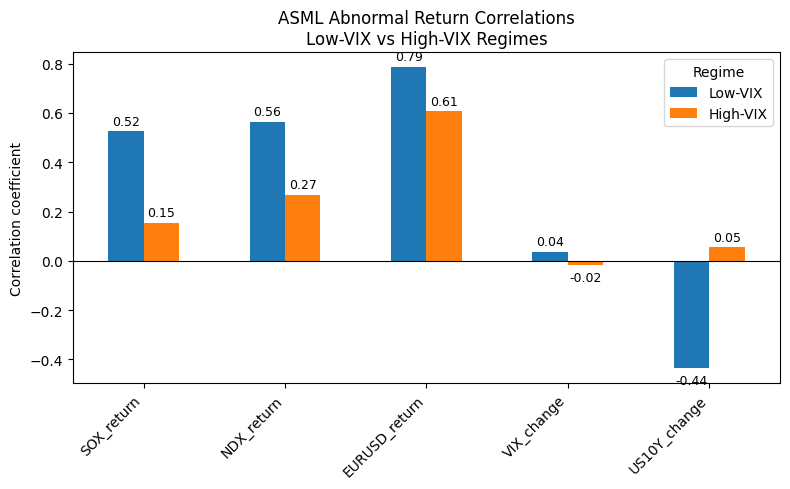

In [22]:
#Now I am visualising these results 
regime_corrs = pd.DataFrame({
    'Low-VIX': low_corrs,
    'High-VIX': high_corrs
})
regime_corrs = regime_corrs.reindex(drivers)

ax = regime_corrs.plot(kind = 'bar', figsize=(8,5))
plt.axhline(0, color='black', linewidth=0.8)
plt.title("ASML Abnormal Return Correlations\nLow-VIX vs High-VIX Regimes")
plt.ylabel("Correlation coefficient")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Regime")
plt.tight_layout()
for container in ax.containers:
    for bar in container:
        y = bar.get_height()
        # Offset label slightly above (or below if negative)
        offset = 0.015 if y >= 0 else -0.025
        ax.annotate(f"{y:.2f}",
                    (bar.get_x() + bar.get_width()/2, y + offset),
                    ha="center", va="bottom" if y >= 0 else "top",
                    fontsize=9)
plt.show()

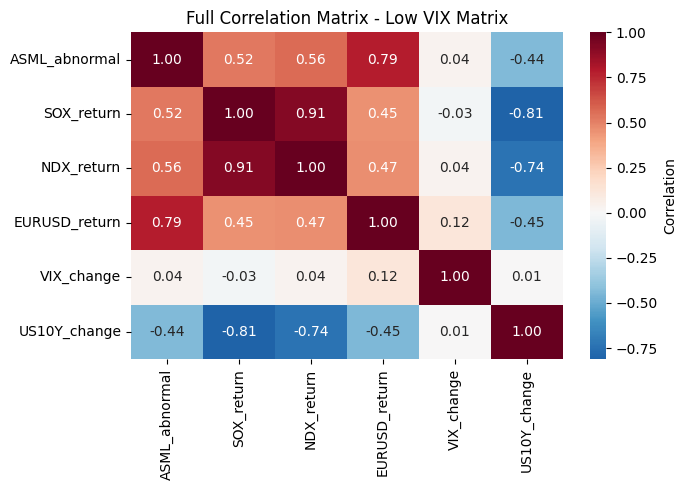

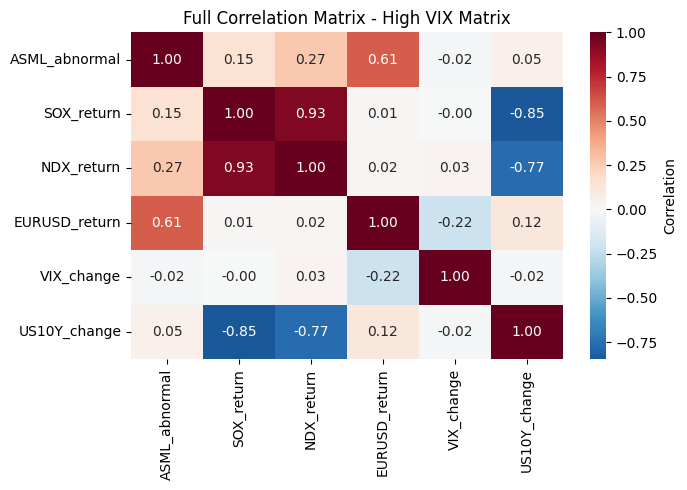

In [23]:
low_corr_matrix = low_clean[['ASML_abnormal']+ drivers].corr()
high_corr_matrix = high_clean[['ASML_abnormal']+ drivers].corr()
plt.figure(figsize=(7,5))
sns.heatmap(
    low_corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar_kws = {'label':'Correlation'}
)
plt.title('Full Correlation Matrix - Low VIX Matrix')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(
    high_corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar_kws = {'label':'Correlation'}
)
plt.title('Full Correlation Matrix - High VIX Matrix')
plt.tight_layout()
plt.show()

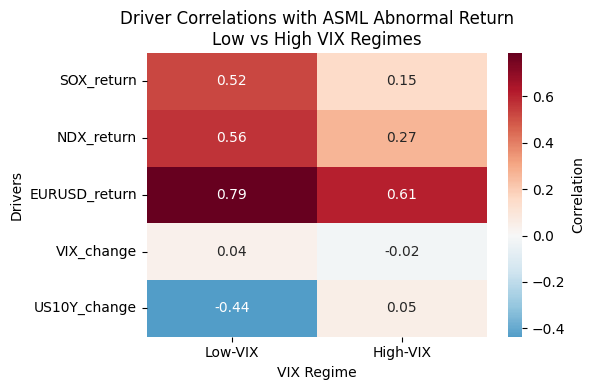

In [24]:
plt.figure(figsize=(6,4))
sns.heatmap(
    regime_corrs,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label':'Correlation'}
)
plt.title('Driver Correlations with ASML Abnormal Return\nLow vs High VIX Regimes')
plt.ylabel('Drivers')
plt.xlabel('VIX Regime')
plt.tight_layout()
plt.show()

#Rolling Correlations
#We want to understand whether the relationships we identified between ASML_abnormal and the drivers is actually stable through time.
#We are going to take 2 windows: 120 days and 90days, considering Trump inauguration and tariff announcement as I think they impacted the stock market and tariifs especially impacted ASML and tech indices.

In [25]:
windows = [90,120]
event_markers = [
    ('Inauguration', pd.Timestamp('2025-01-20')),
    ('Tariff News', pd.Timestamp('2025-04-02')),
    ('Tariff Implementation', pd.Timestamp('2025-04-15'))
]
if not np.issubdtype(eda_data.index.dtype, np.datetime64):
    eda_data = eda_data.copy()
    eda_data.index = pd.to_datetime(eda_data.index)

In [26]:
def rolling_corr_df(df, target_col, drivers, window):
    out = {}
    for d in drivers:
        out[d] = df[target_col].rolling(window).corr(df[d]).rename(d)
    return pd.concat(out.values(), axis=1)

In [27]:
roll_corrs = {w: rolling_corr_df(eda_data, 'ASML_abnormal', drivers, w) for w in windows} 

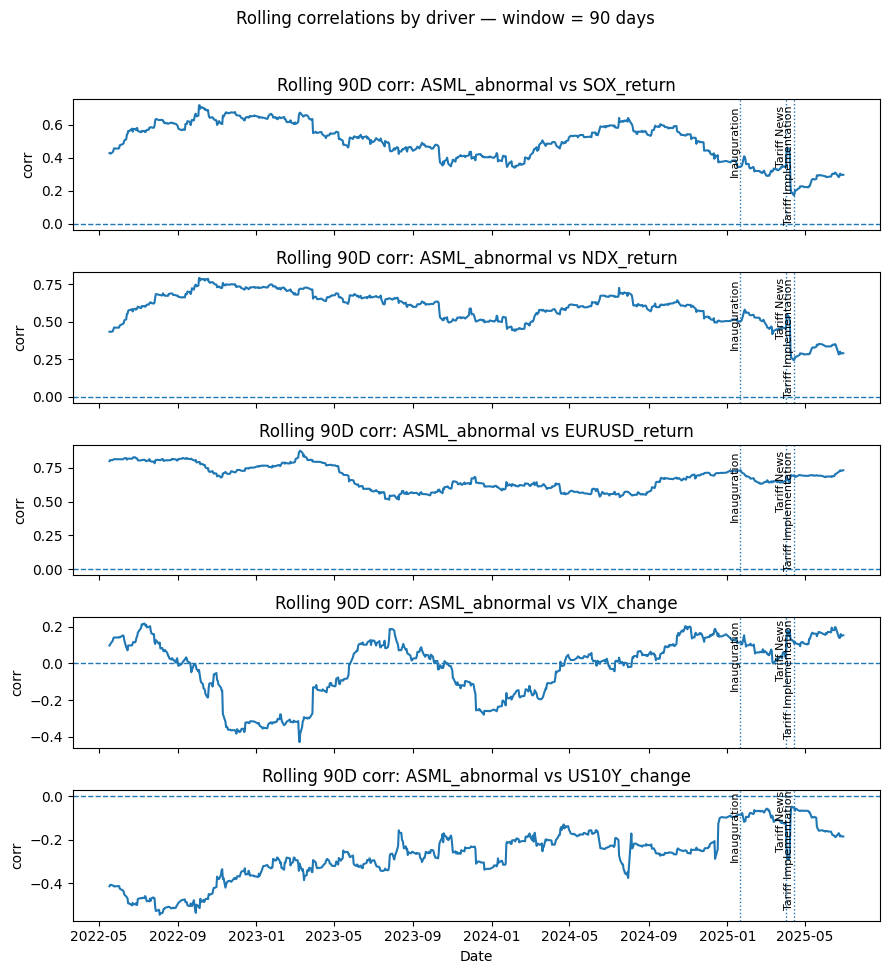

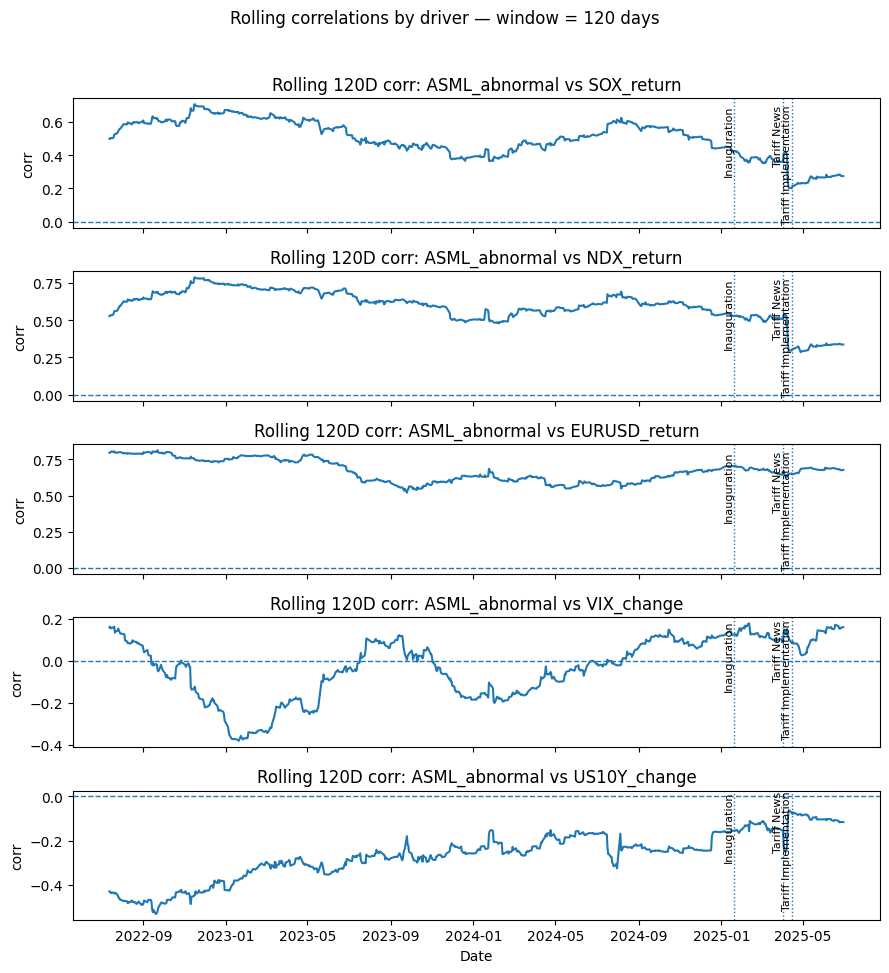

In [28]:
# --- Plot: one small panel per driver, for BOTH windows (stacked), with event markers ---
# This produces two figures: one for 90D, one for 120D
for w in windows:
    dfw = roll_corrs[w]
    n = len(drivers)
    fig, axes = plt.subplots(n, 1, figsize=(9, 1.9*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, d in zip(axes, drivers):
        # line plot of rolling correlation over time
        sns.lineplot(data=dfw[d], ax=ax)
        ax.axhline(0, ls="--", lw=1)  # zero line to spot sign flips quickly
        ax.set_ylabel("corr")
        ax.set_title(f"Rolling {w}D corr: ASML_abnormal vs {d}")

        # vertical event markers
        for label, when in event_markers:
            if dfw.index.min() <= when <= dfw.index.max():
                ax.axvline(when, ls=":", lw=1)
                # tiny label near the top-right of the axis
                ax.text(when, ax.get_ylim()[1]*0.95, label, rotation=90, va="top", ha="right", fontsize=8)

    axes[-1].set_xlabel("Date")
    fig.suptitle(f"Rolling correlations by driver — window = {w} days", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


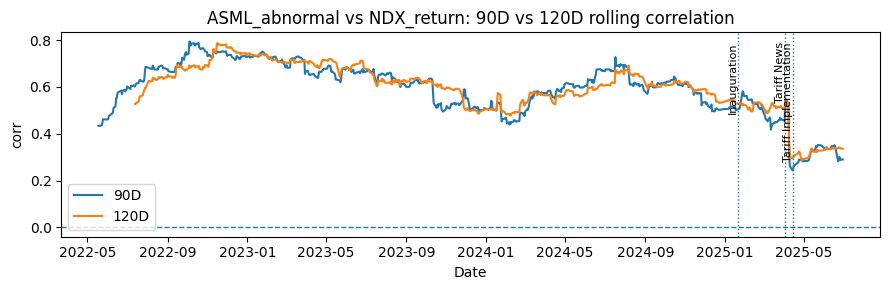

In [29]:
# --- Optional: side-by-side comparison for a SINGLE driver (overlay 90D vs 120D on one axis)
# Pick a driver to compare (e.g., 'SOX_return'); change the name to compare others.
driver_to_compare = "NDX_return"

plt.figure(figsize=(9, 3))
for w in windows:
    sns.lineplot(data=roll_corrs[w][driver_to_compare], label=f"{w}D")
plt.axhline(0, ls="--", lw=1)

# vertical event markers
for label, when in event_markers:
    # only draw if the date is within the plot range
    if roll_corrs[windows[0]].index.min() <= when <= roll_corrs[windows[0]].index.max():
        plt.axvline(when, ls=":", lw=1)
        plt.text(when, plt.gca().get_ylim()[1]*0.95, label, rotation=90, va="top", ha="right", fontsize=8)

plt.title(f"ASML_abnormal vs {driver_to_compare}: 90D vs 120D rolling correlation")
plt.xlabel("Date"); plt.ylabel("corr"); plt.legend(); plt.tight_layout(); plt.show()


In [30]:
if not np.issubdtype(eda_data.index.dtype, np.datetime64):
    eda_data = eda_data.copy()
    eda_data.index = pd.to_datetime(eda_data.index)

#Event dates
inaug = pd.Timestamp('2025-01-20')
tariff_ann = pd.Timestamp('2025-04-02')
tariff_impl = pd.Timestamp('2025-04-15')

#Zoom window for viewing 
zoom_start = pd.Timestamp('2025-03-01')
zoom_end = pd.Timestamp('2025-05-31')

focus_drivers = ['SOX_return', 'NDX_return']

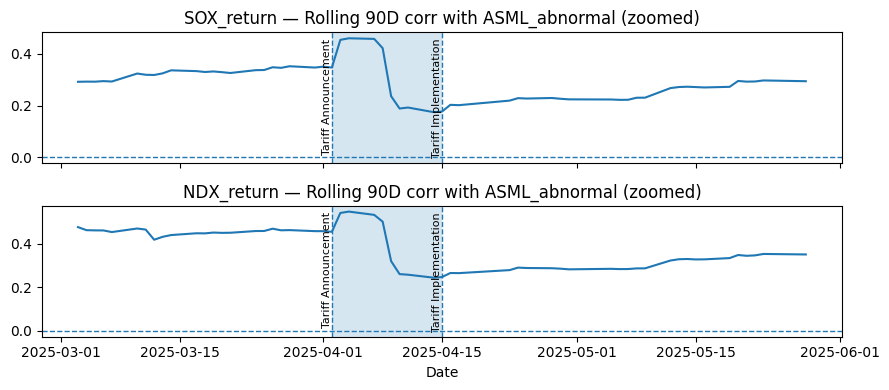

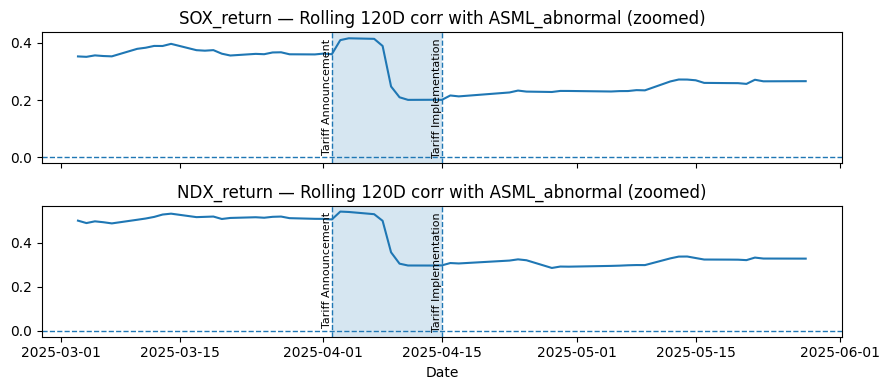

In [31]:
for w in [90, 120]:
    #roll_corrs[w] is a table with rows as dates, columns as drivers and includes rolling correlations for that window. Then, we localize to a specific date range and only show the focus drivers
    dfw = roll_corrs[w].loc[zoom_start : zoom_end, focus_drivers]
    #n is the number of drivers to plot & plt.subplots(..) creates 1 column, n rows of plots, all sharing the same axis (dates)
    n = len(focus_drivers)
    fig, axes = plt.subplots(n, 1, figsize=(9, 2.0*n), sharex = True)
    if n==1:
        axes = [axes]
    for ax, d in zip(axes, focus_drivers):
        sns.lineplot(x=dfw.index, y=dfw[d].values, ax=ax)  #time on the x-axis is the index of dfw, rolling correlation for driver d on the y axis (y=dfw[d].values)
        ax.axhline(0, ls='--', lw=1)
        ax.set_title(f"{d} — Rolling {w}D corr with ASML_abnormal (zoomed)")
        #Shade announcement till implementation window
        ax.axvspan(tariff_ann, tariff_impl, alpha = 0.18, zorder =0) # light transperancy & shading behind the line
        #Event markers
        for label, when in [('Inauguration', inaug), ('Tariff Announcement', tariff_ann), ('Tariff Implementation', tariff_impl)]:
            if dfw.index.min() <= when <= dfw.index.max():
                ax.axvline(when, ls='--', lw=1)
                ax.text(when, ax.get_ylim()[1]*0.95, label, rotation = 90, va = 'top', ha = 'right', fontsize=8)
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

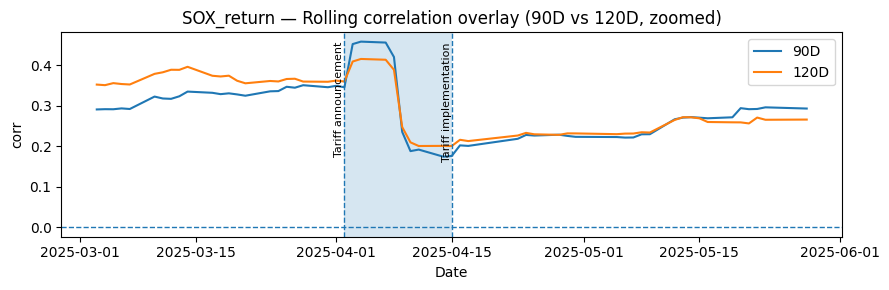

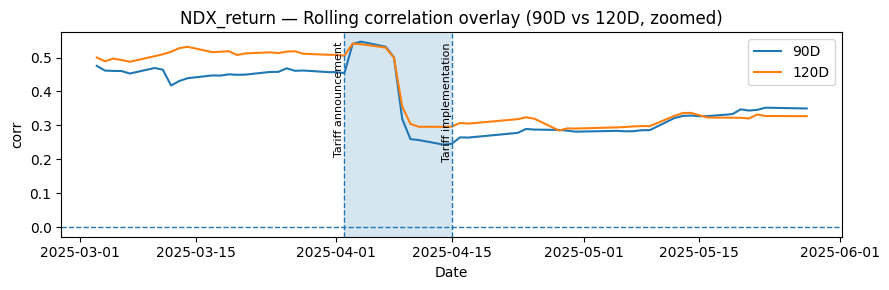

In [32]:
for d in focus_drivers:
    s90  = roll_corrs[90][d].loc[zoom_start:zoom_end]
    s120 = roll_corrs[120][d].loc[zoom_start:zoom_end]

    plt.figure(figsize=(9, 3))
    sns.lineplot(x=s90.index,  y=s90.values,  label="90D")
    sns.lineplot(x=s120.index, y=s120.values, label="120D")
    plt.axhline(0, ls='--', lw=1)

    # Event markers & shading
    plt.axvspan(tariff_ann, tariff_impl, alpha=0.18, zorder=0)
    for label, when in [("Inauguration", inaug), ("Tariff announcement", tariff_ann), ("Tariff implementation", tariff_impl)]:
        if s90.index.min() <= when <= s90.index.max():
            plt.axvline(when, ls='--', lw=1)
            plt.text(when, plt.gca().get_ylim()[1]*0.95, label, rotation=90,
                     va='top', ha='right', fontsize=8)

    plt.title(f"{d} — Rolling correlation overlay (90D vs 120D, zoomed)")
    plt.xlabel("Date"); plt.ylabel("corr"); plt.legend(); plt.tight_layout(); plt.show()


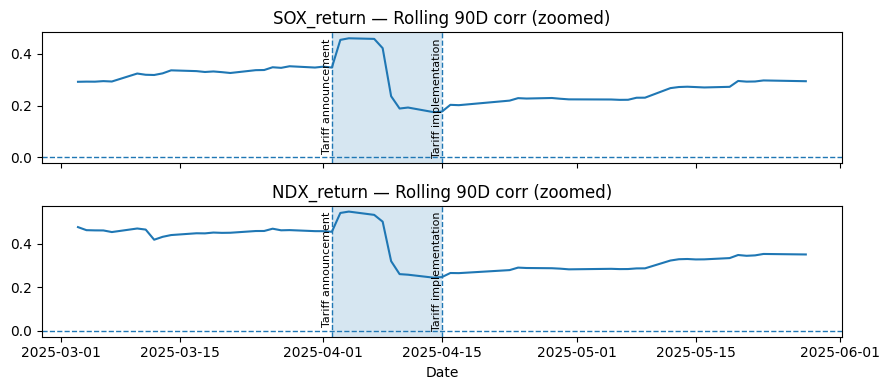

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
for ax, d in zip(axes, focus_drivers):
    s90 = roll_corrs[90][d].loc[zoom_start:zoom_end]
    sns.lineplot(x=s90.index, y=s90.values, ax=ax)
    ax.axhline(0, ls='--', lw=1)
    ax.axvspan(tariff_ann, tariff_impl, alpha=0.18, zorder=0)
    for label, when in [("Inauguration", inaug), ("Tariff announcement", tariff_ann), ("Tariff implementation", tariff_impl)]:
        if s90.index.min() <= when <= s90.index.max():
            ax.axvline(when, ls='--', lw=1)
            ax.text(when, ax.get_ylim()[1]*0.95, label, rotation=90,
                    va='top', ha='right', fontsize=8)
    ax.set_title(f"{d} — Rolling 90D corr (zoomed)")
axes[-1].set_xlabel("Date")
plt.tight_layout(); plt.show()


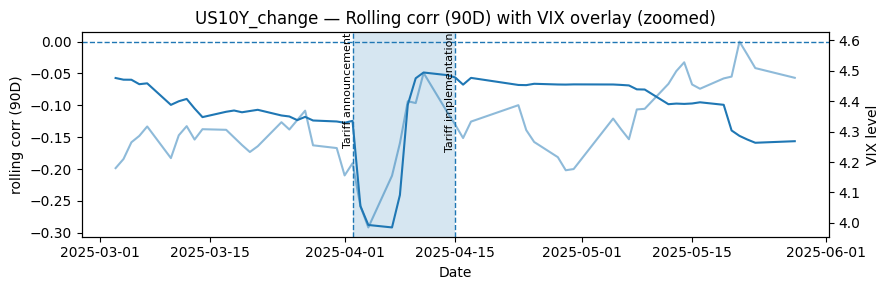

In [45]:
d = "US10Y_change"  # change to "NDX_return" to see the other one
s90 = roll_corrs[90][d].loc[zoom_start:zoom_end]
vix = eda_data["VIX_level"].loc[zoom_start:zoom_end].dropna()

fig, ax1 = plt.subplots(figsize=(9, 3))
sns.lineplot(x=s90.index, y=s90.values, ax=ax1)
ax1.axhline(0, ls='--', lw=1)
ax1.axvspan(tariff_ann, tariff_impl, alpha=0.18, zorder=0)
ax1.set_ylabel("rolling corr (90D)")
ax1.set_title(f"{d} — Rolling corr (90D) with VIX overlay (zoomed)")

# secondary y-axis for VIX
ax2 = ax1.twinx()
sns.lineplot(x=vix.index, y=vix.values, ax=ax2, alpha=0.5)
ax2.set_ylabel("VIX level")

# event lines
for label, when in [("Inauguration", inaug), ("Tariff announcement", tariff_ann), ("Tariff implementation", tariff_impl)]:
    if s90.index.min() <= when <= s90.index.max():
        ax1.axvline(when, ls='--', lw=1)
        ax1.text(when, ax1.get_ylim()[1]*0.95, label, rotation=90, va='top', ha='right', fontsize=8)

plt.tight_layout(); plt.show()


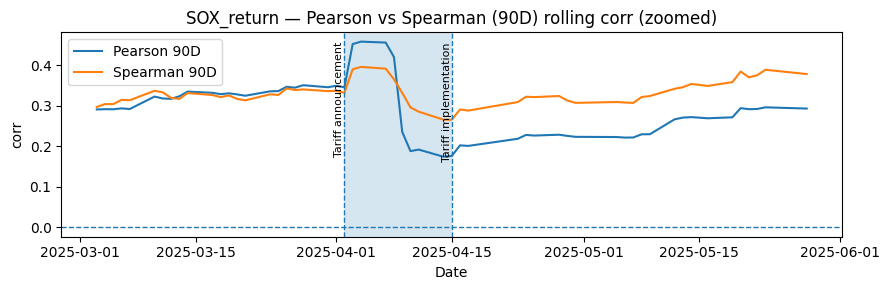

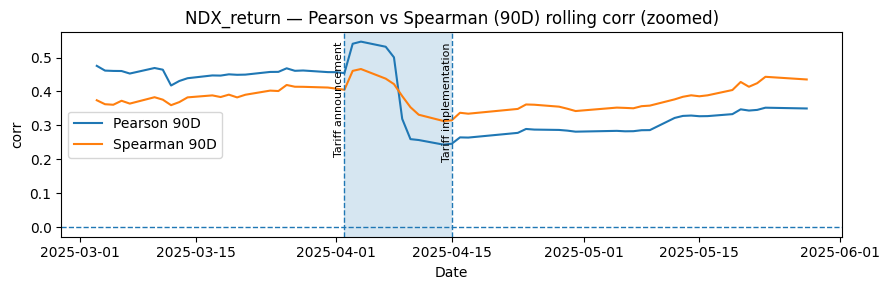

In [52]:
import numpy as np
import pandas as pd

def rolling_spearman_corr(df, target, drv, W, min_obs=None):
    """
    Exact rolling Spearman between df[target] and df[drv], right-aligned, window=W.
    Implementation: rank BOTH series *within each window*, then Pearson on those ranks.
    """
    a = df[target].to_numpy()
    b = df[drv].to_numpy()
    n = len(df)
    out = np.full(n, np.nan)
    if min_obs is None:
        min_obs = W

    for i in range(W - 1, n):
        sa = a[i - W + 1 : i + 1]
        sb = b[i - W + 1 : i + 1]
        m = ~np.isnan(sa) & ~np.isnan(sb)
        if m.sum() >= min_obs:
            # rank within the window (exact Spearman definition)
            ra = pd.Series(sa[m]).rank(method="average").to_numpy()
            rb = pd.Series(sb[m]).rank(method="average").to_numpy()
            # Pearson correlation of the ranks
            out[i] = np.corrcoef(ra, rb)[0, 1]
    return pd.Series(out, index=df.index, dtype=float)
# ensure your date markers are Timestamps
inaug       = pd.to_datetime(inaug)
tariff_ann  = pd.to_datetime(tariff_ann)
tariff_impl = pd.to_datetime(tariff_impl)

for d in focus_drivers:  # e.g., ["SOX_return","NDX_return"]
    # Pearson (already built earlier)
    pearson_full  = roll_corrs[90][d]
    # Spearman (exact) with the function above
    spearman_full = rolling_spearman_corr(eda_data, "ASML_abnormal", d, W=90)

    # zoom or full range
    pearson  = pearson_full.loc[zoom_start:zoom_end]
    spearman = spearman_full.loc[zoom_start:zoom_end]

    plt.figure(figsize=(9, 3))
    sns.lineplot(x=pearson.index,  y=pearson.values,  label="Pearson 90D")
    sns.lineplot(x=spearman.index, y=spearman.values, label="Spearman 90D")
    plt.axhline(0, ls='--', lw=1)

    # same event shading + markers
    plt.axvspan(tariff_ann, tariff_impl, alpha=0.18, zorder=0)
    for label, when in [("Inauguration", inaug), ("Tariff announcement", tariff_ann), ("Tariff implementation", tariff_impl)]:
        if pearson.index.min() <= when <= pearson.index.max():
            plt.axvline(when, ls='--', lw=1)
            plt.text(when, plt.gca().get_ylim()[1]*0.95, label, rotation=90,
                     va='top', ha='right', fontsize=8)

    plt.title(f"{d} — Pearson vs Spearman (90D) rolling corr (zoomed)")
    plt.xlabel("Date"); plt.ylabel("corr"); plt.legend(); plt.tight_layout(); plt.show()


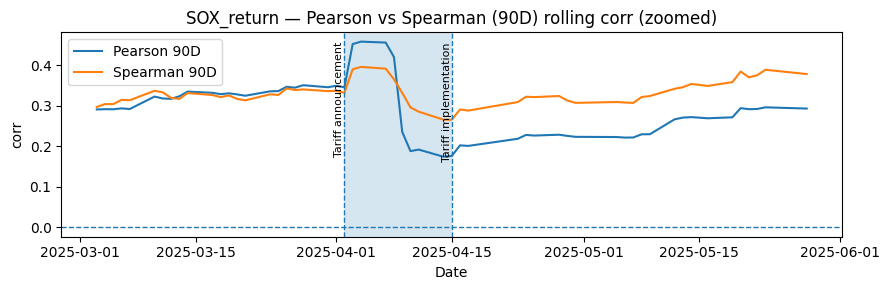

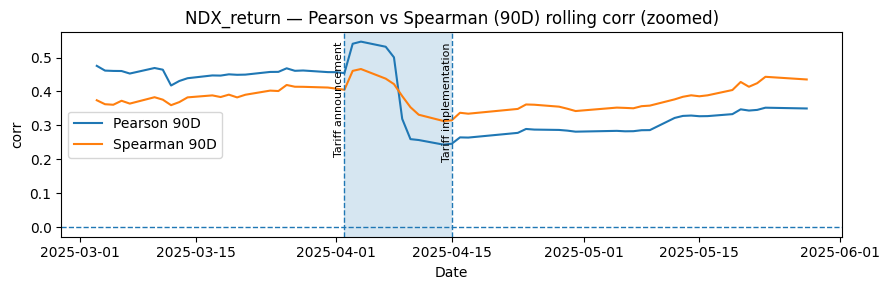

In [54]:
import numpy as np, pandas as pd

def rolling_spearman(df, target, drv, W, min_obs=None):
    """
    Exact rolling Spearman between df[target] and df[drv], right-aligned, window=W.
    Ranks are computed *inside each window*, then Pearson is applied to those ranks.
    """
    a = df[target].to_numpy()
    b = df[drv].to_numpy()
    n = len(df)
    out = np.full(n, np.nan, dtype=float)
    if min_obs is None:
        min_obs = W

    for i in range(W - 1, n):
        sa = a[i - W + 1 : i + 1]
        sb = b[i - W + 1 : i + 1]
        m = ~np.isnan(sa) & ~np.isnan(sb)
        if m.sum() >= min_obs:
            ra = pd.Series(sa[m]).rank(method="average").to_numpy()
            rb = pd.Series(sb[m]).rank(method="average").to_numpy()
            out[i] = np.corrcoef(ra, rb)[0, 1]
    return pd.Series(out, index=df.index, dtype=float)
# Ensure event dates are Timestamp (once)
inaug       = pd.to_datetime(inaug)
tariff_ann  = pd.to_datetime(tariff_ann)
tariff_impl = pd.to_datetime(tariff_impl)

for d in focus_drivers:
    pear  = roll_corrs[90][d].loc[zoom_start:zoom_end]
    spear = rolling_spearman(eda_data, "ASML_abnormal", d, 90).loc[zoom_start:zoom_end]

    plt.figure(figsize=(9, 3))
    sns.lineplot(x=pear.index,  y=pear.values,  label="Pearson 90D")
    sns.lineplot(x=spear.index, y=spear.values, label="Spearman 90D")
    plt.axhline(0, ls='--', lw=1)

    plt.axvspan(tariff_ann, tariff_impl, alpha=0.18, zorder=0)
    for label, when in [("Inauguration", inaug), ("Tariff announcement", tariff_ann), ("Tariff implementation", tariff_impl)]:
        if pear.index.min() <= when <= pear.index.max():
            plt.axvline(when, ls='--', lw=1)
            plt.text(when, plt.gca().get_ylim()[1]*0.95, label, rotation=90,
                     va='top', ha='right', fontsize=8)

    plt.title(f"{d} — Pearson vs Spearman (90D) rolling corr (zoomed)")
    plt.xlabel("Date"); plt.ylabel("corr"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
#Lead-lag profiles

In [40]:
if not np.issubdtype(eda_data.index.dtype, np.datetime64):
    eda_data = eda_data.copy()
    eda_data.index = pd.to_datetime(eda_data.index)

#Target and drivers
target_col = 'ASML_abnormal'

max_lag = 5 #I will compute from -5 to +5
min_obs = 60 #I will consider 60 overlapping days to compute correlation

In [41]:
def lag_corr_profile(y: pd.Series, x: pd.Series, max_lag: int = 5, min_obs: int = 60) -> pd.Series:
    lags = range(-max_lag, max_lag+ 1)
    out={}
    for k in lags:
        xs = x.shift(k)
        pair = pd.concat([y,xs], axis =1).dropna()
        out[k] = pair.iloc[:, 0].corr(pair.iloc[:,1]) if len(pair) >= min_obs else np.nan
    return pd.Series(out, name = x.name)

In [42]:
#Compute profiles for all drivers
y = eda_data[target_col]
lag_profiles = {d: lag_corr_profile(y, eda_data[d], max_lag = max_lag, min_obs=min_obs) for d in drivers}
lag_df = pd.DataFrame(lag_profiles)
lag_df

,SOX_return,NDX_return,EURUSD_return,VIX_change,US10Y_change
-5,0.020368,0.017782,0.003992,-0.072666,-0.046477
-4,0.008011,-0.012515,0.016178,-0.079127,0.020920
-3,-0.028951,-0.029765,-0.056087,-0.015835,0.031784
-2,0.025810,0.020445,0.019634,-0.043928,0.002023
-1,-0.001508,0.003278,-0.048488,-0.030394,-0.009622
0,0.476971,0.548639,0.694116,-0.021124,-0.251084
1,0.145320,0.134325,-0.080867,0.082343,-0.116752
2,-0.024372,-0.017783,0.000597,-0.041106,0.060245
3,-0.012484,-0.017719,-0.035365,-0.088187,-0.035369
4,-0.040401,-0.030468,-0.028148,-0.026737,-0.010097


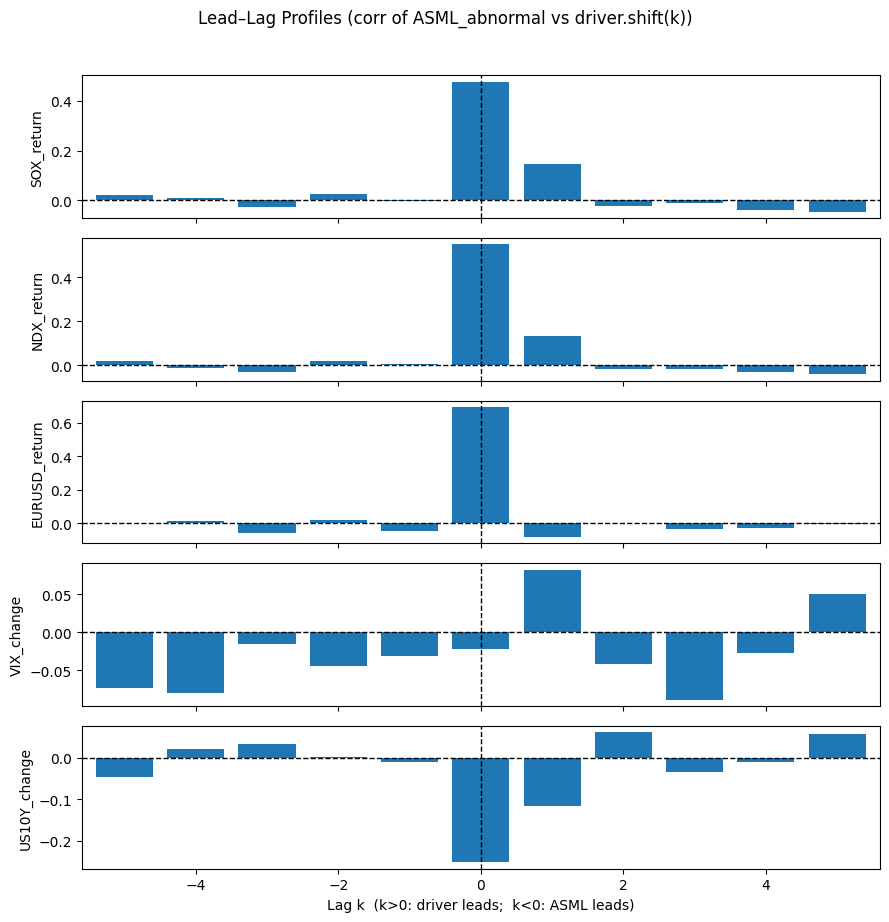

In [43]:
n = len(drivers)
fig, axes = plt.subplots(n, 1, figsize=(9, 1.8*n), sharex=True)

if n==1:
    axes = [axes]

lags = np.arange(-max_lag, max_lag+1)

for ax, d in zip(axes, drivers):
    vals = lag_df[d].values
    ax.bar(lags, vals, width = 0.8)
    ax.axhline(0, ls='--', lw=1, color='black')
    ax.axvline(0, ls='--', lw=1, color='black')
    ax.set_ylabel(d)
    ax.set_xlim(lags.min()-0.6, lags.max()+0.6)

axes[-1].set_xlabel("Lag k  (k>0: driver leads;  k<0: ASML leads)")
fig.suptitle("Lead–Lag Profiles (corr of ASML_abnormal vs driver.shift(k))", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

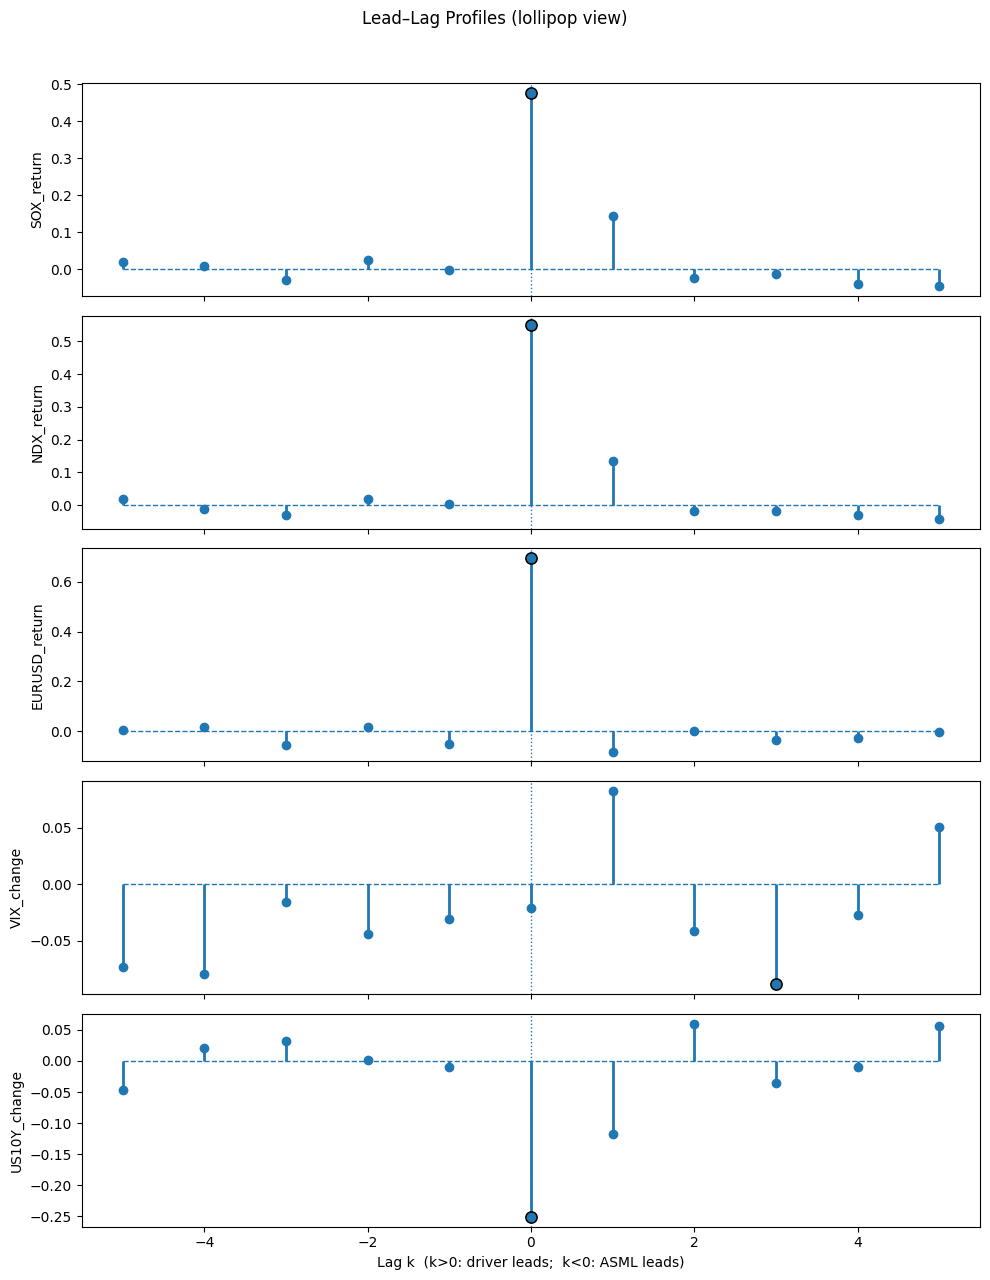

In [44]:
import matplotlib.pyplot as plt

lags = lag_df.index.values
n = len(lag_df.columns)
fig, axes = plt.subplots(n, 1, figsize=(10, 2.5*n), sharex=True)

if n == 1: axes = [axes]

for ax, drv in zip(axes, lag_df.columns):
    vals = lag_df[drv].values
    ax.hlines(y=0, xmin=lags.min(), xmax=lags.max(), linestyles='--', linewidth=1)
    ax.vlines(lags, 0, vals, linewidth=2)         # stems
    ax.plot(lags, vals, 'o', ms=6)                 # lollipop heads
    ax.axvline(0, ls=':', lw=1)                    # separates leads vs lags
    # highlight the best lag
    k_best = lags[np.nanargmax(np.abs(vals))]
    v_best = vals[np.nanargmax(np.abs(vals))]
    ax.plot(k_best, v_best, 'o', ms=8, mfc='none', mec='black', mew=1.2)
    ax.set_ylabel(drv)

axes[-1].set_xlabel("Lag k  (k>0: driver leads;  k<0: ASML leads)")
fig.suptitle("Lead–Lag Profiles (lollipop view)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()


In [57]:
# If you already have `lagged_corrs` (rows=drivers, cols=lags), skip this cell.

lags = list(range(-5, 6))  # -5..+5
results = {}

for d in focus_drivers:  # e.g., ["SOX_return","NDX_return","EURUSD_change","VIX_change","US10Y_change", ...]
    corrs = []
    for L in lags:
        corrs.append(eda_data["ASML_abnormal"].corr(eda_data[d].shift(L)))
    results[d] = corrs

lagged_corrs = pd.DataFrame(results, index=lags).T  # rows=drivers, cols=lags


In [58]:
import numpy as np
import pandas as pd

def summarize_driver(row):
    # row: a Series indexed by lags (-5..+5) with corr values
    lag0_corr = row.get(0, np.nan)
    # best positive
    pos_lag = row.idxmax()
    pos_val = row.loc[pos_lag]
    # best negative
    neg_lag = row.idxmin()
    neg_val = row.loc[neg_lag]
    # strongest by absolute value
    abs_lag = row.abs().idxmax()
    abs_val = row.loc[abs_lag]
    direction = ("leads ASML (driver at negative lag)"
                 if abs_lag < 0 else
                 ("co-moves (lag 0)" if abs_lag == 0 else
                  "lags ASML (driver at positive lag)"))
    return pd.Series({
        "lag0_corr":      lag0_corr,
        "best_pos_corr":  pos_val,
        "best_pos_lag":   pos_lag,
        "best_neg_corr":  neg_val,
        "best_neg_lag":   neg_lag,
        "strongest_corr": abs_val,
        "strongest_lag":  abs_lag,
        "interpretation": direction
    })

lagged_summary = lagged_corrs.apply(summarize_driver, axis=1)
# Order by absolute strength of the strongest correlation (desc)
lagged_summary = lagged_summary.reindex(
    lagged_summary["strongest_corr"].abs().sort_values(ascending=False).index
)

lagged_summary.round(3)


,lag0_corr,best_pos_corr,best_pos_lag,best_neg_corr,best_neg_lag,strongest_corr,strongest_lag,interpretation
NDX_return,0.549,0.549,0,-0.042,5,0.549,0,co-moves (lag 0)
SOX_return,0.477,0.477,0,-0.045,5,0.477,0,co-moves (lag 0)


In [ ]:
#Step 7: Regime-Conditional Lagged Profiles

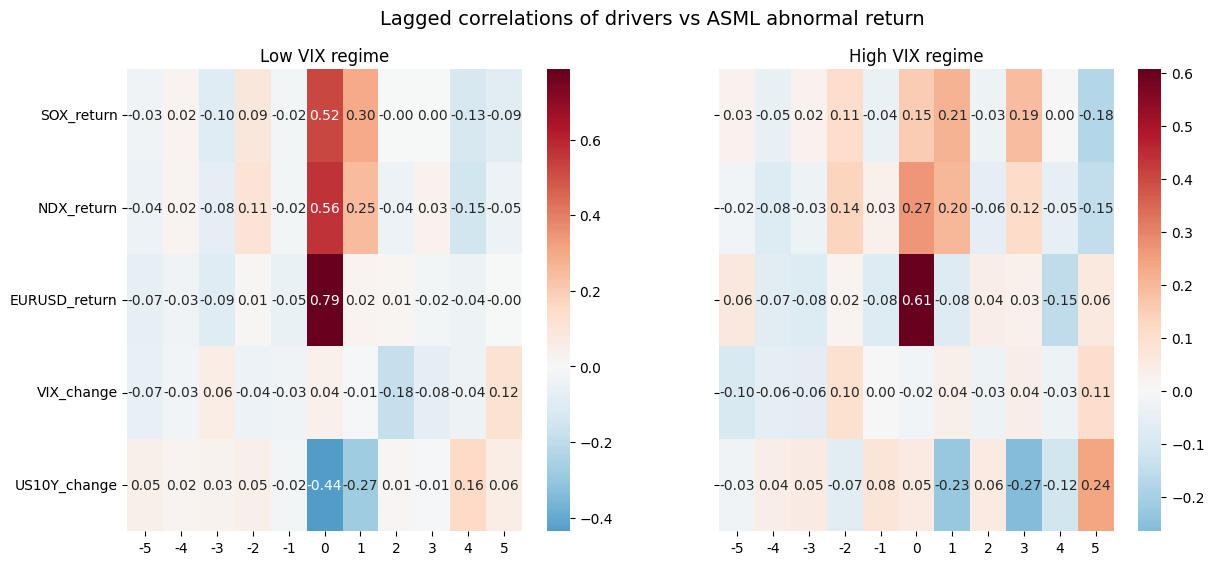

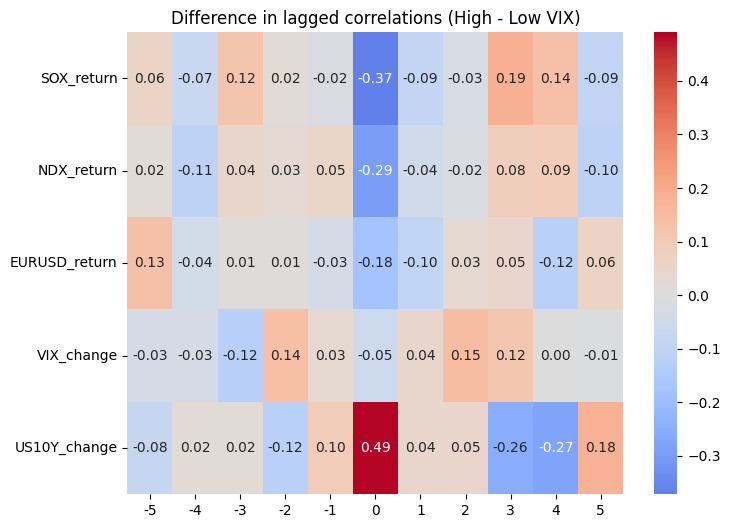

In [67]:
lags = range(-5, 6)

def compute_lagged_profiles(df, target, drivers, lags):
    results = {}
    for d in drivers:
        corrs = []
        for L in lags:
            corrs.append(df[target].corr(df[d].shift(L)))
        results[d] = corrs
    return pd.DataFrame(results, index=lags).T

#Compute within regimes
lagged_low = compute_lagged_profiles(low_reg, 'ASML_abnormal', drivers, lags)
lagged_high = compute_lagged_profiles(high_reg, 'ASML_abnormal', drivers, lags)

#Plot side by side heatmaps
fig, axes = plt.subplots(1,2, figsize=(14,6), sharey = True)
sns.heatmap(lagged_low, annot = True, center = 0, cmap='RdBu_r', ax=axes[0], fmt='.2f')
axes[0].set_title('Low VIX regime')

sns.heatmap(lagged_high, annot = True, center = 0, cmap='RdBu_r', ax=axes[1], fmt='.2f')
axes[1].set_title('High VIX regime')

plt.suptitle('Lagged correlations of drivers vs ASML abnormal return', fontsize=14)
plt.show()

#Difference view
lagged_diff = lagged_high - lagged_low
plt.figure(figsize=(8,6))
sns.heatmap(lagged_diff, annot = True, center=0, cmap='coolwarm', fmt='.2f')
plt.title('Difference in lagged correlations (High - Low VIX)')
plt.show()

In [ ]:
#Yearlt stability

In [71]:
#Ensure datetime index
if not np.issubdtype(eda_data.index.dtype, np.datetime64):
    eda_data.index = pd.to_datetime(eda_data.index)

years = [y for y in [2023, 2024, 2025] if (eda_data.index.year == y).any()]

def corr_vector_for_year(df, year, target, drivers):
    sub = df[df.index.year == year]
    out = {}
    for d in drivers:
        s = sub[[target, d]].dropna()
        out[d] = s[target].corr(s[d]) if len(s) > 2 else np.nan
    return pd.Series(out, name=year)

#Build driver x correlartion table
year_corrs = pd.concat([corr_vector_for_year(eda_data, y, 'ASML_abnormal', drivers)
                        for y in years], axis = 1)

#Order drivers by average absolute correlation across years (most impactful on top)
order = year_corrs.abs().mean(axis=1).sort_values(ascending = False).index
year_corrs = year_corrs.loc[order]

display(year_corrs.round(3))

,2023,2024,2025
EURUSD_return,0.639,0.644,0.681
NDX_return,0.592,0.564,0.355
SOX_return,0.445,0.475,0.297
US10Y_change,-0.258,-0.153,-0.176
VIX_change,-0.093,0.064,0.149


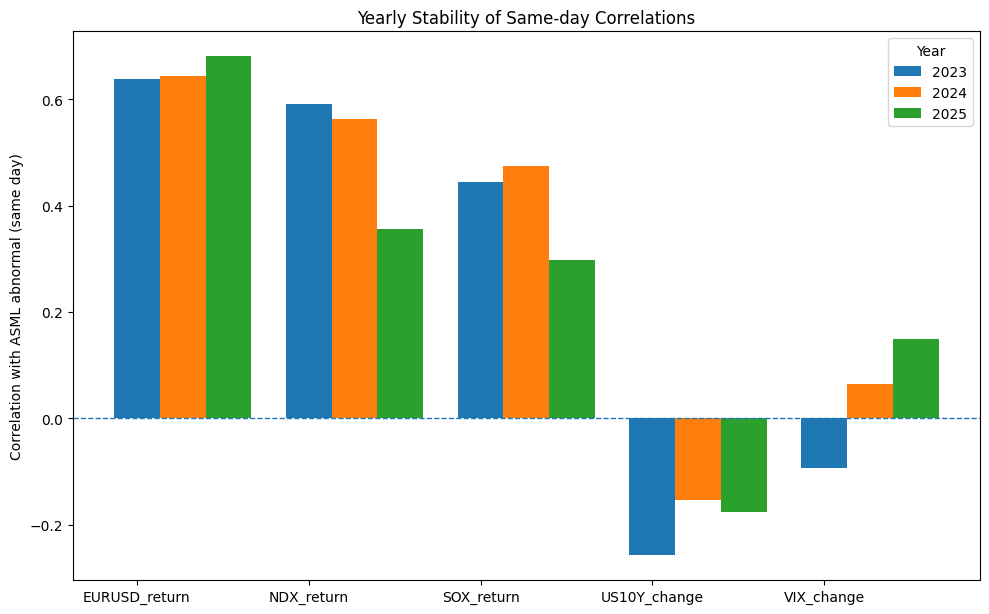

In [74]:
#Plot grouped bars for quick comparison
plt.figure(figsize=(10, 5 + 0.25*len(year_corrs)))
x = np.arange(len(year_corrs.index))
width = 0.8 / len(years)

for i, y in enumerate(years):
    plt.bar(x+ i * width - 0.4 + width*(len(years)/2), year_corrs[y].values, width, label = str(y))

plt.axhline(0, linestyle='--', linewidth =1)
plt.xticks(x, year_corrs.index, rotation=0)
plt.ylabel("Correlation with ASML abnormal (same day)")
plt.title("Yearly Stability of Same-day Correlations")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

In [78]:
#Stability summary per driver: std and range across years
stab = pd.DataFrame({
    'mean_corr': year_corrs.mean(axis=1),
    'std_across_years': year_corrs.std(axis=1),
    'min_year': year_corrs.idxmin(axis=1),
    'min_corr':year_corrs.min(axis=1),
    'max_year': year_corrs.idxmax(axis=1),
    'max_corr': year_corrs.max(axis=1),
})

#Lower std = more stab;e across years
stab = stab.loc[order]
display(stab.round(3))

,mean_corr,std_across_years,min_year,min_corr,max_year,max_corr
EURUSD_return,0.655,0.023,2023,0.639,2025,0.681
NDX_return,0.503,0.129,2025,0.355,2023,0.592
SOX_return,0.406,0.095,2025,0.297,2024,0.475
US10Y_change,-0.196,0.055,2023,-0.258,2024,-0.153
VIX_change,0.040,0.123,2023,-0.093,2025,0.149


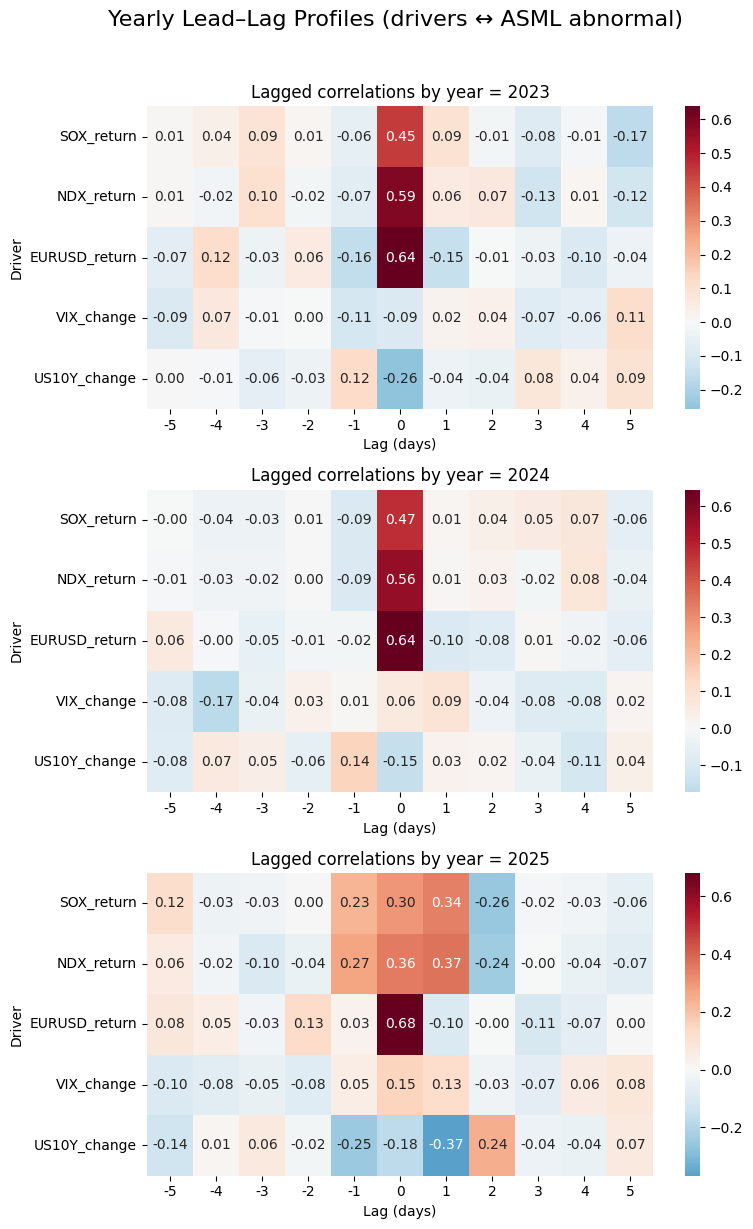

In [91]:
#Yearly lagged profiles(+-5)
lags = range(-5, 6)

def lagged_profiles_df(df, target, drivers, lags):
    res = {}
    for d in drivers:
        vals = []
        for L in lags:
            pair = df[[target,d]].copy()
            pair[d] = pair[d].shift(L)
            pair = pair.dropna()
            vals.append(pair[target].corr(pair[d]) if len(pair) > 2 else np.nan)
        res[d] = vals
    return pd.DataFrame(res, index = lags).T #rows=drovers, cols=lags

fig, axes = plt.subplots(len(years), 1, figsize=(8, 4*len(years)), sharey=True)
if len(years) == 1:
    axes = [axes]

for ax, y in zip(axes, years):
    sub= eda_data[eda_data.index.year == y]
    lagM = lagged_profiles_df(sub, 'ASML_abnormal', drivers, lags)
    sns.heatmap(lagM, annot=True, fmt = '.2f', cmap= 'RdBu_r', center = 0, ax=ax, cbar= True, annot_kws={'size': 10})
    ax.set_title(f"Lagged correlations by year = {y}", fontsize=12)
    ax.set_xlabel("Lag (days)", fontsize=10)
    ax.set_ylabel("Driver", fontsize=10)

plt.suptitle("Yearly Lead–Lag Profiles (drivers ↔ ASML abnormal)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# 3-regime VIX split

In [93]:
low_thr = eda_data['VIX_level'].quantile(0.20)
high_thr = eda_data['VIX_level'].quantile(0.80)

low_reg = eda_data[eda_data['VIX_level'] <=low_thr]
mid_reg = eda_data[(eda_data['VIX_level'] > low_thr) & (eda_data['VIX_level'] < high_thr)]
high_reg = eda_data[eda_data['VIX_level'] > high_thr]
print('Counts:', len(low_reg), len(mid_reg), len(high_reg))

Counts: 161 480 161


In [96]:
def corr_vector(df, target, driver):
    out = {}
    for d in drivers:
        tmp = df[[target, d]].dropna()
        out[d] = tmp[target].corr(tmp[d]) if len(tmp)> 2 else float('nan')
    return pd.Series(out)

corrs_low = corr_vector(low_reg, 'ASML_abnormal', drivers)
corrs_mid = corr_vector(mid_reg, 'ASML_abnormal', drivers)
corrs_high = corr_vector(high_reg, 'ASML_abnormal', drivers)

regime_corrs = pd.DataFrame({'Low VIX': corrs_low, 'Mid VIX': corrs_mid, 'High VIX': corrs_high})

#Order drivers by average corr across regimes (strongest first)
regime_corrs = regime_corrs.loc[regime_corrs.abs().mean(axis=1).sort_values(ascending = False).index]
regime_corrs.round(3)

,Low VIX,Mid VIX,High VIX
EURUSD_return,0.786,0.671,0.606
NDX_return,0.563,0.633,0.268
SOX_return,0.525,0.553,0.153
US10Y_change,-0.436,-0.293,0.055
VIX_change,0.037,-0.047,-0.018


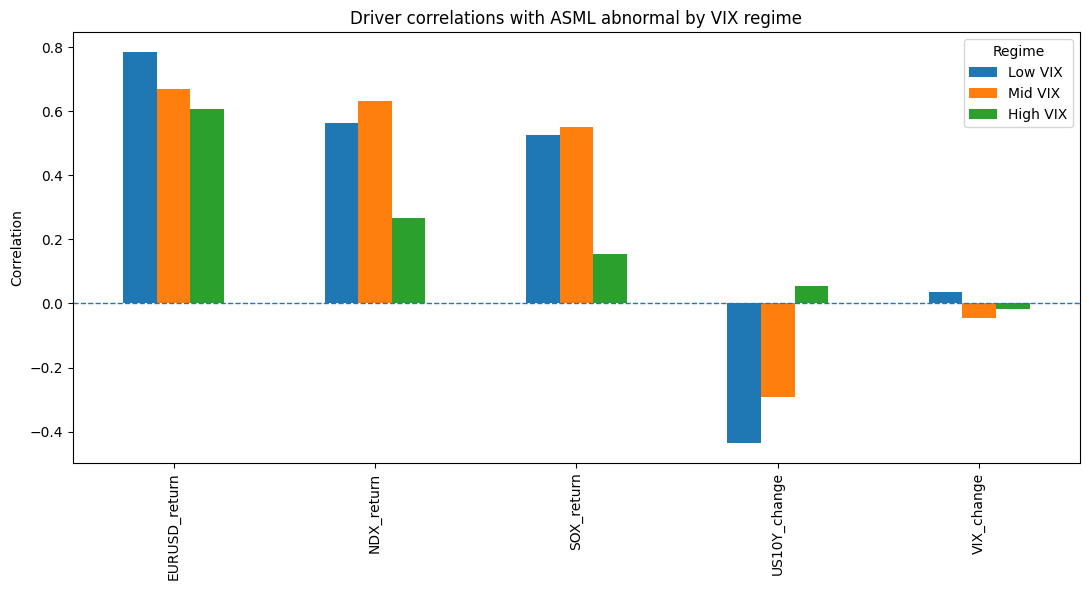

In [97]:
# Grouped bars for quick visual comparison
ax = regime_corrs.plot(kind="bar", figsize=(11, 6))
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Driver correlations with ASML abnormal by VIX regime")
ax.set_ylabel("Correlation")
ax.legend(title="Regime", loc="best")
plt.tight_layout()
plt.show()


In [ ]:
#Partial Effects

In [100]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Build Regression dataset
x = eda_data[drivers].dropna()
y = eda_data.loc[x.index, 'ASML_abnormal']

#Add constant for intercept
x_constant = sm.add_constant(x)

#Run OLS Regression
model = sm.OLS(y, x_constant).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ASML_abnormal   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 24 Sep 2025   Prob (F-statistic):          1.24e-155
Time:                        17:47:09   Log-Likelihood:                 2184.1
No. Observations:                 802   AIC:                            -4356.
Df Residuals:                     796   BIC:                            -4328.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.941

In [103]:
def run_regression(df, drivers, target='ASML_abnormal'):
    x = df[drivers].dropna()
    y = df.loc[x.index, target]
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    return model

#Run OLS separately for each regime
ols_low = run_regression(low_reg, drivers)
ols_mid = run_regression(mid_reg, drivers)
ols_high = run_regression(high_reg, drivers)

print('=== Low VIX Regime ===')
print(ols_low.summary())
print('=== Mid VIX Regime ===')
print(ols_mid.summary())
print('=== High VIX Regime ===')
print(ols_high.summary())

=== Low VIX Regime ===
                            OLS Regression Results                            
Dep. Variable:          ASML_abnormal   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     54.79
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           1.49e-32
Time:                        18:12:48   Log-Likelihood:                 430.04
No. Observations:                 161   AIC:                            -848.1
Df Residuals:                     155   BIC:                            -829.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.000

In [102]:
#Check multicollinearity (VIF)
#Variance Inflation Factor (VIF) for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = x_constant.columns
vif_data['VIF'] = [variance_inflation_factor(x_constant.values, i)
                   for i in range(x_constant.shape[1])]
vif_data

,Variable,VIF
0,const,1.002063
1,SOX_return,6.550688
2,NDX_return,5.366854
3,EURUSD_return,1.212829
4,VIX_change,1.018636
5,US10Y_change,2.044334
